![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> Lecture 13 - Bayesian Regression </center>
### <center> Bayesian Optimization </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethod/13_BayesianRegression/MainGlobalBayesianOptimization.ipynb)

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

### Generate some data:
$$\mathcal{D}_{\text{train}}=\left\{ \left(x_{i},y_{i}\right)\right\} _{i=1}^{N}$$
$$y_{i}=f\left(x_{i}\right)+\epsilon_{i}$$

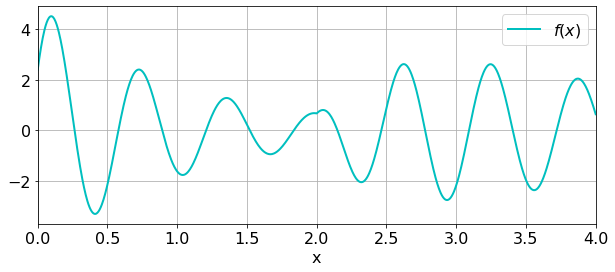

In [2]:
def f(vX):
    return 5 * np.exp(-vX) * np.sin(10*vX + .5) * (1 + (vX > 2) * 10 * (vX - 2))

M   = 1001;
vX0 = np.linspace(0, 4, M);

plt.figure(figsize=(10, 4))
plt.plot(vX0, f(vX0), 'c', lw=2, label='$f(x)$')
plt.xlabel('x')
plt.xlim([0, 4])
plt.grid()
plt.legend()
plt.show()

### Define a kernel:

In [3]:
from scipy.spatial.distance import cdist

#-- Gaussian kernel:
def k(mX1, mX2, σ):
    mD = cdist(mX2, mX1)
    return np.exp(-mD**2 / (2 * σ**2))

### For each $x_0$ compute $f_{Y_{0}|\underline{Y}}\left(y_{0}|\boldsymbol{y}\right)$:
$$\boxed{f_{Y_{0}|\underline{Y}}\left(y_{0}|\boldsymbol{y}\right)=\mathcal{N}\left(y_{0}|\mu_{y_{0}},\sigma_{y_{0}}^{2}\right)}$$
$$\mu_{y_{0}}=\boldsymbol{k}_{0}^{T}\left(\boldsymbol{K}+\frac{\sigma_{\epsilon}^{2}}{\sigma_{w}^{2}}\boldsymbol{I}\right)^{-1}\boldsymbol{y}$$
$$\sigma_{y_{0}}^{2}=k_{0,0}-\boldsymbol{k}_{0}^{T}\left(\boldsymbol{K}+\frac{\sigma_{\epsilon}^{2}}{\sigma_{w}^{2}}\boldsymbol{I}\right)^{-1}\boldsymbol{k}_{0}+\sigma_{\epsilon}^{2}$$
where:
$$\boldsymbol{K}\left[i,j\right]=k\left(\boldsymbol{x}_{i},\boldsymbol{x}_{j}\right)$$
$$\boldsymbol{k}_{0}\left[i\right]=k\left(\boldsymbol{x}_{0},\boldsymbol{x}_{i}\right)$$
$$k_{0,0}=k\left(\boldsymbol{x}_{0},\boldsymbol{x}_{0}\right)$$

In [4]:
def KernelBaysesianRegression(mX, vY, mX0, σ_ε, σ_w, k):
    λ     = (σ_ε / σ_w)**2
    N     = mX.shape[0]
    mK    = k(mX, mX)
    mInvK = np.linalg.inv(mK + λ * np.eye(N))
    mK0   = k(mX0, mX)
    
    vY0   = (mK0.T @ mInvK @ vY[:,None]).squeeze()
    vVar0 = 1 - np.sum((mK0.T @ mInvK) * mK0.T, axis=1) + σ_ε**2
    vσ0   = np.sqrt(np.maximum(vVar0, 0))
    
    return (vY0, vσ0)

###  Bayesian optimization:
$$\boldsymbol{x}_{t}\leftarrow\arg\underset{\boldsymbol{x}_{0}\in\mathcal{X}}{\min}\mu_{y_{0}}-\tau\sigma_{y_{0}}$$

In [5]:
def PlotBayesianOptimization(N):
    σ_ε = 0.02
    σ_w = 2
    𝜏   = 5

    def GaussianKernel(mX1, mX2):
        σ = 0.2
        return k(mX1, mX2, σ)

    mX = np.full((N, 1), np.nan)
    vY = np.full(N,      np.nan)
    for ii in range(N):
        if ii == 0:
            mX[0,:] = 2
            vY[0]   = f(mX[0,:])
        else:
            mX[ii,:] = vX0[idx]
            vY[ii]   = f(vX0[idx])

        mXi      = mX[:ii+1,:]
        vYi      = vY[:ii+1]
        vY0, vσ0 = KernelBaysesianRegression(mXi, vYi, vX0[:,None], σ_ε, σ_w, GaussianKernel)
        idx      = np.argmin(vY0 - 𝜏 * vσ0)

    plt.figure(figsize=(16, 6))
    plt.fill_between(vX0, vY0 - 2*vσ0, vY0 + 2*vσ0, color='gray', alpha=0.3, label='$\pm 2\sigma_{y}$')
    plt.plot(vX0, f(vX0), 'c',   lw=2,                                       label='$f(x)$')
    plt.plot(vX0, vY0,    '--r', lw=2,                                       label='$\hat{f}(x)$')
    plt.scatter(mX[:,0], vY, s=50, c='b', edgecolor='k',                     label='$y_i = f(x_i) + \epsilon_i$')
    plt.axvline(x=vX0[idx], lw=2, ls='--', c='g')
    plt.xlabel('x')
    plt.grid()
    plt.legend(fontsize=14, loc='lower right')


In [6]:
from ipywidgets import interact, IntSlider, Layout

nSlider = IntSlider(min=1, max=100, step=1, value=1, layout=Layout(width='80%'))
interact(PlotBayesianOptimization, N=nSlider)
plt.show()

interactive(children=(IntSlider(value=1, description='N', layout=Layout(width='80%'), min=1), Output()), _dom_…

### Boston data:

In [7]:
from sklearn.datasets import load_boston

mX, vY = load_boston(return_X_y=True)
mX.shape, vY.shape

((506, 13), (506,))

In [8]:
N   = mX.shape[0]
mX -= mX.mean(axis=0)
mX /= mX.std(axis=0)
vY -= vY.mean()
vY /= vY.std()

### The function to minimize:
We use $-R^2$ score (with cross validation).  
$\gamma$ is the unknown parameter.

In [9]:
from sklearn.kernel_ridge    import KernelRidge
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score

def CrossValScore(ɣ, kFold=50):
    vHatY = cross_val_predict(KernelRidge(kernel='rbf', gamma=10**ɣ, alpha=0.016), mX, vY, cv=KFold(kFold, shuffle=True))
    return -r2_score(vY, vHatY)

In [10]:
CrossValScore(0.01)

-0.6891402032273907

#### Bayesian optimization:

In [12]:
def BayesianOptimization(f, N, xx,  σ_ε=0.02, σ_w=2, σ=0.2, 𝜏=2):
    
    def GaussianKernel(mX1, mX2):
        mD = cdist(mX2, mX1)
        return np.exp(-mD**2 / (2 * σ**2))

    mX = np.full((N, xx.shape[1]), np.nan)
    vY = np.full(N,                np.nan)
    for ii in range(N):
        if ii == 0:
            idx = np.random.randint(xx.shape[0])
            
        mX[ii,:] = xx[idx,:]
        vY[ii]   = f(*mX[ii,:])

        mXi    = mX[:ii+1,:]
        vYi    = vY[:ii+1]
        yy, σσ = KernelBaysesianRegression(mXi, vYi, xx, σ_ε, σ_w, GaussianKernel)
        idx    = np.argmin(yy - 𝜏 * σσ)

    return mX, vY, yy, σσ
        

### Apply algorithm:

In [13]:
#-- Search interval:
vɣ               = np.linspace(-2, -0.8, 201)
#-- Apply algorithm:
mXX, vYY, yy, vσ = BayesianOptimization(CrossValScore, 200, vɣ[:,None], 𝜏=5)

mXX.shape, vYY.shape, yy.shape, vσ.shape

((200, 1), (200,), (201,), (201,))

 #### Plot:

[]

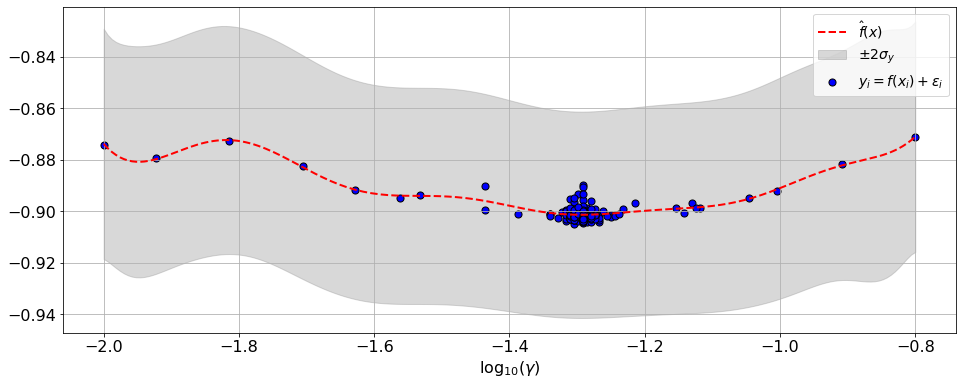

In [14]:
vXX = mXX.squeeze()

plt.figure(figsize=(16, 6))
plt.fill_between(vɣ, yy - 2*vσ, yy + 2*vσ, color='gray', alpha=0.3, label='$\pm 2\sigma_{y}$')
plt.plot(vɣ, yy,    '--r', lw=2,                                    label='$\hat{f}(x)$')
plt.scatter(vXX, vYY, s=50, c='b', edgecolor='k',                   label='$y_i = f(x_i) + \epsilon_i$')
plt.xlabel('$\log_{10}(\gamma)$')
plt.grid()
plt.legend(fontsize=14)
plt.plot()

In [15]:
idx = np.where(vYY == vYY.min())
vɣ[idx]

array([-1.706])

In [16]:
vYY.min()

-0.9048715275366701

In [17]:
CrossValScore(vɣ[idx], kFold=N)

-0.8882147203062325

### (Advanced) exercise
* Modify the code and search both $\gamma$ and $\alpha$.
* Improve the $R^2$ score.

In [74]:
from sklearn.kernel_ridge    import KernelRidge
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score

def CrossValScore(ɣ, α, kFold=50):
    ???

In [18]:
???

Object `?` not found.


 #### Plot:

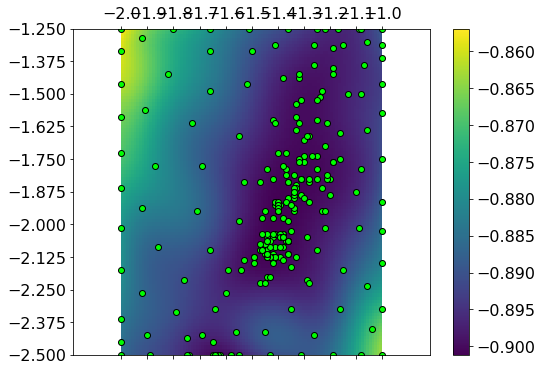

In [77]:
mYY   = np.reshape(yy, mɣ.shape)
_, ax = plt.subplots(figsize=(8, 6))
c     = ax.matshow(mYY, extent=[vɣ.min(), vɣ.max(), vα.min(), vα.max()], origin='lower')
plt.scatter(mXX[:,0], mXX[:,1], c='lime', edgecolor='k')
ax.set_xticks(vɣ[::10])
ax.set_yticks(vα[::10])
plt.colorbar(c, ax=ax)
plt.axis('equal')
plt.show()

In [81]:
yIdx, xIdx = np.where(mYY == mYY.min())
vɣ[xIdx], vα[yIdx]

In [80]:
CrossValScore(vɣ[xIdx], vα[yIdx], kFold=N)

-0.9021801012645249